In [1]:
import gc
import torch
import sys

gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install rouge_score
!pip install datasets==1.0.2
!pip install transformers==4.24.0
!pip install transformer-utils
!pip install packaging
!pip install wandb

In [3]:
# mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-19 16:12:18--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-19 16:12:18--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb777575de72a687cf361012ee5.dl.dropboxusercontent.com/cd/0/get/BxCjcXPOYKSg2zdK8yIoUJrBdpVoyOx4OFT9rDTlGXSLhBJESWI2AvtELbb4IBuaUoXVXXTL9G4ZEHMjVpMgFvFTPkkT8Wi8N6Hv0P_sy5EJlcx0UXOhGy5irJXo0N_NtWjjELwj55RUfr0Lo9OCxuidquIkXogMUhPDei1IQKrerIDEJPH-BAY8Pn9FdPpa3fo/file?dl=1# [following]
--2022-11-19 16:12:18--  https://ucb777575de72a687cf361012ee5.dl.dropboxusercontent.com/cd/0/get/BxCjcXPOYKSg

In [4]:
# 필요한 라이브러리 불러오기
import datasets
import transformers
import pandas as pd
from datasets import Dataset



import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset,
    EarlyStoppingCallback

)

from transformers import RobertaTokenizerFast
from transformers import EncoderDecoderModel
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
from tabulate import tabulate
from konlpy.tag import Mecab

In [5]:
model_checkpoints = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [6]:
train_textfile_path = "data/train_text.csv"
val_textfile_path = "data/val_text.csv"

with open(train_textfile_path, encoding="utf-8") as f:
            train_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]     

with open(val_textfile_path, encoding="utf-8") as f:
            val_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]


In [7]:
del train_textlines[0]
del val_textlines[0]

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (..) 제거
    sentence = re.sub(r'[#@]+[가-힣A-Za-z#]+', ' ', sentence)
    sentence = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+[/ㄱ-ㅎㅏ-ㅣ]', '', sentence) # 여러개 자음과 모음을 삭제한다.
    sentence = re.sub("[^가-힣a-z0-9]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개 공백을 하나의 공백으로 바꿉니다.
    sentence = sentence.strip() # 문장 양쪽 공백 제거

    return sentence

In [9]:
# 전체 Text 데이터에 대한 전처리 (1)
train_text = []
val_text = []

for tt in tqdm(train_textlines):
    train_text.append(preprocess_sentence(tt))

for vt in tqdm(val_textlines):
      val_text.append(preprocess_sentence(vt))


100%|██████████| 35004/35004 [00:01<00:00, 35002.69it/s]


In [10]:
train_text[0]

'그럼 날짜는 가격 큰 변동 없으면 6 28 7 13로 확정할까 우리 비행포함 15일이야 16일 아 이름 아 너 나한테 돈 보내주면 지금 할 수 잇옹 얼마야 최종 결제액이 잠시만 인당 952 900 합쳐서 1 905 800 근데 나중에 특가 뜰 수도 있으려나 좀 더 두고볼까 뜨기야 뜨겠지 웅웅 보니까 아시아나는 특가 이벤트 꽤 하는 것 같아서 일단 두고보장 그래 구럼 일단 자자'

In [11]:
train_df = pd.DataFrame(zip(train_textlines), columns=['Text'])
val_df = pd.DataFrame(zip(val_textlines), columns=['Text'])

In [12]:
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [13]:
train_df.head()

,Text
0,그럼 날짜는 가격 큰 변동 없으면 6 28 7 13로 확정할까 우리 비행포함 15일...
1,kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2,아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3,칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남ㅋㅋㅋ 아 그 왕칫솔 또 사려...
4,잠도안오네ㅐ얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...


In [14]:
mecab = Mecab()

def sentence_len_total(data):
    text_split_text = []
    # 반복문으로 Mecab 적용
    for text_sen in tqdm(data['Text'].iloc[range(0, len(data))]):
        text_split_text.append(mecab.morphs(text_sen))
    
    temp = pd.DataFrame(zip(text_split_text), columns=['Text'])
    
    # Mecab 적용 후 길이 출력
    text_len = temp.Text.map(len)
    
    # text_len 사분위수 구하기    
    text_Q1 = text_len.quantile(.25)
    text_Q3 = text_len.quantile(.75)
    text_IQR = text_Q3 - text_Q1
    text_Q2 = text_len.quantile(.5)
    text_Q4 = text_len.quantile(1)
    text_threshold_len_left = text_Q1 - (1.5 * text_IQR)
    text_threshold_len_right = text_Q3 + (1.5 * text_IQR)

    
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    print('텍스트의 왼쪽 울타리 범위 : {}'. format(text_threshold_len_left),
         '텍스트의 오른쪽 울타리 범위 : {}'. format(text_threshold_len_right))
    print('text_Q1 = {}'.format(text_Q1), 'headlines_Q1 = {}'.format(text_Q1))
    print('text_Q3 = {}'.format(text_Q3), 'headlines_Q3 = {}'.format(text_Q3))
    print('text_IQR = {}'.format(text_IQR), 'headlines_IQR = {}'.format(text_IQR))
    print('text_Q2 = {}'.format(text_Q2), 'headlines_Q2 = {}'.format(text_Q2))
    print('text_Q4 = {}'.format(text_Q4), 'headlines_Q4 = {}'.format(text_Q4))

    
    plt.subplot(1,1,1)
    plt.boxplot(text_len)
    plt.title('text')
    plt.show()

    plt.title('text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    return data


100%|██████████| 279992/279992 [01:16<00:00, 3656.75it/s]


텍스트의 최소 길이 : 9
텍스트의 최대 길이 : 937
텍스트의 평균 길이 : 60.851017171919196
텍스트의 왼쪽 울타리 범위 : -0.5 텍스트의 오른쪽 울타리 범위 : 115.5
text_Q1 = 43.0 headlines_Q1 = 43.0
text_Q3 = 72.0 headlines_Q3 = 72.0
text_IQR = 29.0 headlines_IQR = 29.0
text_Q2 = 55.0 headlines_Q2 = 55.0
text_Q4 = 937.0 headlines_Q4 = 937.0


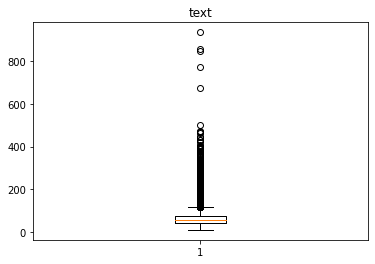

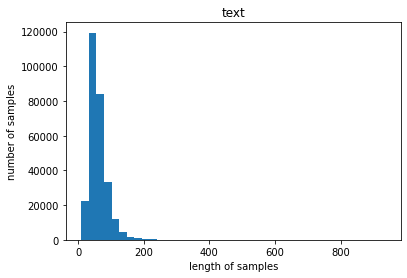

,Text
0,그럼 날짜는 가격 큰 변동 없으면 6 28 7 13로 확정할까 우리 비행포함 15일...
1,kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2,아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3,칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남ㅋㅋㅋ 아 그 왕칫솔 또 사려...
4,잠도안오네ㅐ얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...
...,...
279987,도착하샸나염 자리잡고 알려주이소 아아 ㅋㅋㅋㅋ나 다이소좀 구경하느랔ㅋㅋㅋㅋㅋ 웅 이...
279988,시간잘봐라 겁나 여러가지다 예약내역 올려바바 그러게 호텔은 언제해여 표사고 오늘밤
279989,언제 도착요정이십니까 15분뒤 도착이룝 옥희여 이제 나오묜 될듯 나나홨오 나와ㅉ오 ...
279990,근데 현인가요제 가면 최소20시간은 줄서서 기다려야하는거아님 ㅜ 그정도는아니고 한 ...


In [15]:
sentence_len_total(train_df)

100%|██████████| 35004/35004 [00:09<00:00, 3595.41it/s]


텍스트의 최소 길이 : 10
텍스트의 최대 길이 : 554
텍스트의 평균 길이 : 61.192692263741286
텍스트의 왼쪽 울타리 범위 : -2.0 텍스트의 오른쪽 울타리 범위 : 118.0
text_Q1 = 43.0 headlines_Q1 = 43.0
text_Q3 = 73.0 headlines_Q3 = 73.0
text_IQR = 30.0 headlines_IQR = 30.0
text_Q2 = 55.0 headlines_Q2 = 55.0
text_Q4 = 554.0 headlines_Q4 = 554.0


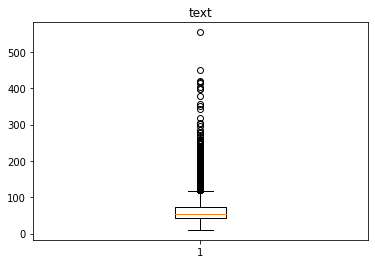

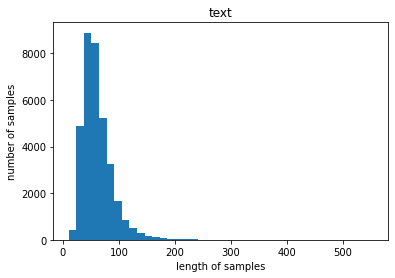

,Text
0,웅 영업팀과장님이 보내줬는데 팀장님이 해줄지 모르겠다 저번에 부산갈때도 숙소로 엄청...
1,너는 잘가라회사 선택 잘해 알겠어 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 많이 힘들구나 나도 이제 이력...
2,느낌상 대통령까지는 아니고 오시면 여사님정도오시지않을까 ㅋㅋㅋ 그러면서 샘 여기있었...
3,숨만수이ㅓ도 숨만쉬어도 100 이내 한달안에 일 무조건 해야대 아 딱한달 그냥 아무...
4,목요일은 외근이구 금요일은 출장 금요일이 당진이양 아닝아닝 10일이 당진이야 그럼 ...
...,...
34999,방금 샐러드 정기배송 주문한 거 먹었눈데 시스템 사진 왜 먹어도 배고푸야 샐러드 정...
35000,닭갈비 맛있었다 ㅋㅋ 맛나맛나 그티웅 ㅋㅋㅋ 아깐 먹기 싫다더니 역시 너의 선택 ㅋ...
35001,나 핫바 먹어야지 먹을래 아니 난 안 무거 그럼 나만 먹는다잉 핫바 찍어먹을 소스 ...
35002,아 본죽에 신메뉴 나온 거 알아 오 신메뉴 나온 걸 왜 못봤지 언니는 오늘 갔었는데...


In [16]:
sentence_len_total(val_df)

In [17]:
print(train_df.head())
print(val_df.head())

                                                Text
0  그럼 날짜는 가격 큰 변동 없으면 6 28 7 13로 확정할까 우리 비행포함 15일...
1  kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2  아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3  칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남ㅋㅋㅋ 아 그 왕칫솔 또 사려...
4  잠도안오네ㅐ얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...
                                                Text
0  웅 영업팀과장님이 보내줬는데 팀장님이 해줄지 모르겠다 저번에 부산갈때도 숙소로 엄청...
1  너는 잘가라회사 선택 잘해 알겠어 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 많이 힘들구나 나도 이제 이력...
2  느낌상 대통령까지는 아니고 오시면 여사님정도오시지않을까 ㅋㅋㅋ 그러면서 샘 여기있었...
3  숨만수이ㅓ도 숨만쉬어도 100 이내 한달안에 일 무조건 해야대 아 딱한달 그냥 아무...
4  목요일은 외근이구 금요일은 출장 금요일이 당진이양 아닝아닝 10일이 당진이야 그럼 ...


In [18]:
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)

In [19]:
max_input = 128
max_target = 128
batch_size = 4
ignore_index = -100

In [20]:
def add_ignored_data(inputs, max_len, ignore_index):
    if len(inputs) < max_len:
        pad = [ignore_index] *(max_len - len(inputs)) # ignore_index즉 -100으로 패딩을 만들 것인데 max_len - lne(inpu)
        inputs = np.concatenate([inputs, pad])
    else:
        inputs = inputs[:max_len]

    return inputs

In [21]:
def preprocess_data(data_to_process):
    label_id= []
    label_ids = []

    inputs = [dialogue for dialogue in data_to_process['Text']]
    model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)

    for i in range(len(data_to_process['Text'])):
        label_id.append(tokenizer.encode(data_to_process['Text'][i]))  
    for i in range(len(data_to_process['Text'])):
        label_id[i].append(tokenizer.eos_token_id)
        label_ids.append(add_ignored_data(label_id[i], max_target, ignore_index))

    model_inputs['labels'] = label_ids

    return model_inputs

In [22]:
train_tokenize_data = train_data.map(preprocess_data, batched = True, remove_columns=['Text'])
val_tokenize_data = val_data.map(preprocess_data, batched = True, remove_columns=['Text'])

  0%|          | 0/280 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

In [23]:

model.config.decoder_start_token_id = tokenizer.bos_token_id                                             
model.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 2


In [24]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     print("labels_ids",labels_ids)
#     print("labels_ids[labels_ids == -100]",labels_ids[labels_ids == -100])
#     print("tokenizer.pad_token_id",tokenizer.pad_token_id)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_outputL = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
    

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
        
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4), 
        
        "rougeL_precision": round(rouge_outputL.precision, 4),
        "rougeL_recall": round(rouge_outputL.recall, 4),
        "rougeL_fmeasure": round(rouge_outputL.fmeasure, 4),
    }

In [37]:
training_args = Seq2SeqTrainingArguments(
    output_dir="MLM_pretrain_6ep_221120",
    num_train_epochs=5,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,  # demo
    per_device_eval_batch_size=16,
    learning_rate=3e-05,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True, # 생성기능을 사용하고 싶다고 지정한다.
    logging_dir="logs2",
    logging_steps=5000,
    save_total_limit=3,
  #  evaluation_strategy = "epoch",# step별로 2버 loss가 오르는거 아니면 계속 반복하는듯
 #   load_best_model_at_end = True,
#    save_strategy='epoch'

    

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [39]:
trainer = Seq2SeqTrainer(
    model, 
    training_args,
    train_dataset=train_tokenize_data,
    eval_dataset=val_tokenize_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [40]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 279992
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 87500
  Number of trainable parameters = 123859968
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
5000,4.410500
10000,4.123600
15000,4.005100
20000,3.923000
25000,3.869700
30000,3.833400
35000,3.806700
40000,3.759600
45000,3.730300
50000,3.723800


Saving model checkpoint to MLM_pretrain_6ep_221120/checkpoint-500
Configuration saved in MLM_pretrain_6ep_221120/checkpoint-500/config.json
Model weights saved in MLM_pretrain_6ep_221120/checkpoint-500/pytorch_model.bin
tokenizer config file saved in MLM_pretrain_6ep_221120/checkpoint-500/tokenizer_config.json
Special tokens file saved in MLM_pretrain_6ep_221120/checkpoint-500/special_tokens_map.json
Saving model checkpoint to MLM_pretrain_6ep_221120/checkpoint-1000
Configuration saved in MLM_pretrain_6ep_221120/checkpoint-1000/config.json
Model weights saved in MLM_pretrain_6ep_221120/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in MLM_pretrain_6ep_221120/checkpoint-1000/tokenizer_config.json
Special tokens file saved in MLM_pretrain_6ep_221120/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to MLM_pretrain_6ep_221120/checkpoint-1500
Configuration saved in MLM_pretrain_6ep_221120/checkpoint-1500/config.json
Model weights saved in MLM_pretrain_6ep_22112

TrainOutput(global_step=87500, training_loss=3.8001913839285715, metrics={'train_runtime': 48030.9623, 'train_samples_per_second': 29.147, 'train_steps_per_second': 1.822, 'total_flos': 1.067008315097088e+17, 'train_loss': 3.8001913839285715, 'epoch': 5.0})

In [41]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 35004
  Batch size = 16


{'eval_loss': 8.68995189666748,
 'eval_rouge1_precision': 0.0118,
 'eval_rouge1_recall': 0.0342,
 'eval_rouge1_fmeasure': 0.0157,
 'eval_rouge2_precision': 0.0006,
 'eval_rouge2_recall': 0.0023,
 'eval_rouge2_fmeasure': 0.0008,
 'eval_rougeL_precision': 0.0117,
 'eval_rougeL_recall': 0.0339,
 'eval_rougeL_fmeasure': 0.0156,
 'eval_runtime': 5099.0122,
 'eval_samples_per_second': 6.865,
 'eval_steps_per_second': 0.429,
 'epoch': 5.0}

In [42]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Text"],
        padding="max_length",
        truncation=True,
        max_length=max_target,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, num_beams=2,no_repeat_ngram_size=2, max_length=128,
                            suppress_tokens= [234,23782,14338,240,199,198,161,116, 14338, 239], 
                             attention_mask=attention_mask, top_p=0.92)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)# 여기에 기본 kobart가져오기?
import random
from random import randrange
ck_num = len(test_data)
test_samples = test_data.select(range(0, ck_num, 500))# 0, len(test_data), 200

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1] # 여기에 체크포인트 가져오기 
# 연구해봐야한다.

loading configuration file config.json from cache at /aiffel/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/f9f2ec35d3c32a1ecc7a3281f9626b7ec1913fed/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "gogamza/kobart-base-v2",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "

NameError: name 'test_data' is not defined

In [ ]:
for i in range(len(summaries_after_tuning)):
    print('idx_{} '.format(i))
    print("Summary before \n", summaries_before_tuning[i])
    print()
    print("Summary after \n", summaries_after_tuning[i])
    print()
    print("Target summary \n", test_samples["Summary"][i])
    print()
    print('Text', test_samples["Text"][i])
    print('-'*100)
    print()  